In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

In [ ]:
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
# Modified to test different learning rates
learningRates = [3e-3, 3e-4, 3e-5]
ratesResultValLoss = {'0.00300' :[], '0.00030': [], '0.00003': []}

for i in learningRates:
  learning_rate_str = format(i, '.5f')
  print('Learning Rate: ', i)
  model = GPTLanguageModel()
  m = model.to(device)
  # print the number of parameters in the model
  print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

  # create a PyTorch optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr=i)

  for iter in range(max_iters):

      # every once in a while evaluate the loss on train and val sets
      if iter % eval_interval == 0 or iter == max_iters - 1:
          losses = estimate_loss()
          print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
      ratesResultValLoss[learning_rate_str].append((iter, losses['val']))
      # sample a batch of data
      xb, yb = get_batch('train')

      # evaluate the loss
      logits, loss = model(xb, yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

  # generate from the model
  context = torch.zeros((1, 1), dtype=torch.long, device=device)
  print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
  #open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

Learning Rate:  0.003
10.788929 M parameters
step 0: train loss 4.2558, val loss 4.2437
step 500: train loss 2.2093, val loss 2.2607
step 1000: train loss 1.7517, val loss 1.9000
step 1500: train loss 1.6885, val loss 1.8565
step 2000: train loss 1.7066, val loss 1.8746
step 2500: train loss 1.8303, val loss 1.9819
step 3000: train loss 2.6434, val loss 2.6601
step 3500: train loss 2.7328, val loss 2.7458
step 4000: train loss 2.8450, val loss 2.8542
step 4500: train loss 2.7556, val loss 2.7674
step 4999: train loss 2.7742, val loss 2.7877

TtS trlaonVweClat iseesh ma oKI
Ar'otylNn  thopbTetay , YCe, atksoit. arerh ikaukg,ey t ts dche amirianoo
W:aolfkwires. the:yid
Clor ce auu bf-r Rcel yO
ats,hemuRoicrWhelh d f bcufnen ere he istdd, shicith'soLt  el ivhin  wfuneven turasefuTe hyh
etofrerwitt:
't w ind e irer;ci:hre admR  aayea uat'es, tttohed;siseelndd annr etconyonore thoflor otthetdso ape, gdor orhimde o t h c;yermd fced a.
Ason ,
Whncole, owhisddofOra:tarO:ount m m, meadinry lwfk

In [ ]:
iters_003, val_loss_003 = zip(*ratesResultValLoss['0.00300'])
iters_0003, val_loss_0003 = zip(*ratesResultValLoss['0.00030'])
iters_00003, val_loss_00003 = zip(*ratesResultValLoss['0.00003'])

val_loss_003 = [x.item() for x in val_loss_003]
val_loss_0003 = [x.item() for x in val_loss_0003]
val_loss_00003 = [x.item() for x in val_loss_00003]

[4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183532715,
 4.2436652183

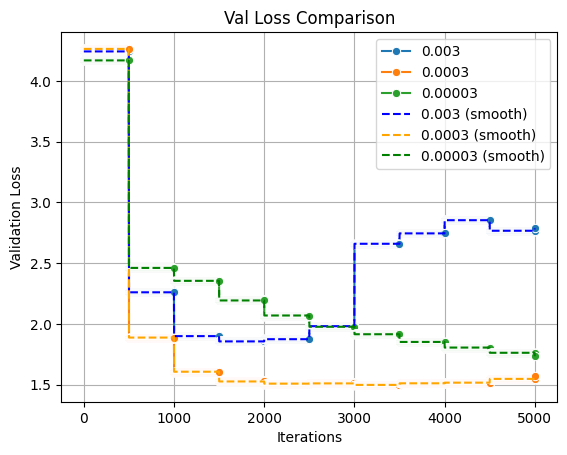

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

iters_003, val_loss_003 = zip(*ratesResultValLoss['0.00300'])
iters_0003, val_loss_0003 = zip(*ratesResultValLoss['0.00030'])
iters_00003, val_loss_00003 = zip(*ratesResultValLoss['0.00003'])

val_loss_003 = [x.item() for x in val_loss_003]
val_loss_0003 = [x.item() for x in val_loss_0003]
val_loss_00003 = [x.item() for x in val_loss_00003]

fig, ax = plt.subplots()

sns.lineplot(x=iters_003, y=val_loss_003, marker='o', label='0.003', ax=ax)
sns.lineplot(x=iters_0003, y=val_loss_0003, marker='o', label='0.0003', ax=ax)
sns.lineplot(x=iters_00003, y=val_loss_00003, marker='o', label='0.00003', ax=ax)

plt.title("Val Loss Comparison")
plt.xlabel("Iterations")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)

sns.lineplot(x=iters_003, y=val_loss_003, label='0.003 (smooth)',  ax=ax, color='blue', linestyle='--')
sns.lineplot(x=iters_0003, y=val_loss_0003, label='0.0003 (smooth)', ax=ax, color='orange', linestyle='--')
sns.lineplot(x=iters_00003, y=val_loss_00003, label='0.00003 (smooth)', ax=ax, color='green', linestyle='--')

plt.show()